Este primer avance consiste en realizar un análisis exploratorio de datos (EDA - Exploratory Data Analysis), es decir, describir los datos utilizando técnicas estadísticas y de visualización (análisis univariante y bi/multivariante) para hacer enfoque en sus aspectos más relevantes, así como aplicar y justificar operaciones de preprocesamiento, relacionadas con el manejo de valores faltantes, atípicos y alta cardinalidad. Es importante que incluyan sus conclusiones del EDA, identificando tendencias o relaciones importantes.


## Equipo 7:

- Luis Salomon Flores Ugalde A00817435

### Importaciones

In [1]:
import pandas as pd
import torch

from PIL import Image

from jupyterthemes import jtplot
import os

import dlib
from mtcnn import MTCNN

from matplotlib import pyplot as plt


jtplot.style()

## Importación de Utilidades


<h4 style="bold">Como primer paso en governanza, algunas cosas se han hecho clase y otras función. Esto también para facilitar la refactorización en las siguientes iteraciones.</4>

In [37]:
from utils.analysis_utils import check_corrupt
from utils.dataframe_torch_imagefolder import DataframeTorchImageFolder

from utils.metrics_util import batch_sharpness, batch_calculate_image_metrics,batch_image_shape
from utils.flatter import batch_flatten_img
from utils.face_detection_util import batch_dataset_face_detection_cnn,batch_dataset_face_detection_dlib,process_batch_results

### Utils plot

In [3]:
def plot_random_images(images_df, title, sample=5):
    # Select 10 random images
    random_samples = images_df.sample(n=sample)
    
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    fig.suptitle(title, fontsize=15)
    
    for ax, (_, row) in zip(axes.flatten(), random_samples.iterrows()):
        img_path = row["img_path"]
        label = row["class"]
        #class_name = dataset.classes[label]
        
        try:
            img = Image.open(img_path)
           # print(img_path)
            name = os.path.basename(img_path.replace(data_dir, ""))
            parent_folder = os.path.dirname(img_path.replace(data_dir, "")).split(os.sep)[-1]
            ax.imshow(img)
            ax.set_title(str(label)+" "+name+" "+parent_folder, fontsize=12)
            ax.axis('off')
        except Exception as e:
            ax.set_title("Error loading image")
            ax.axis('off')

    plt.tight_layout()
    plt.show()


<h4 style="bold">
Se trabaja en una Mac con procesador Silicon M2 Ultra, cualquier threading o proceso de torch toma en cuenta esta restricción pero no se limita completamente.  
</h4>

### Preprocessing

In [38]:
torch.cuda.is_available()
num_workers = os.cpu_count()
print(num_workers)

12


In [4]:
data_dir ="/Users/lsfu/Desktop/MNA/Integrador/MTTX/data/"

In [5]:
test_dataset = DataframeTorchImageFolder(data_dir+'NETv3', data_transforms=None)

In [6]:
batch_flatten_img(
    test_dataset.imagefolder_dataset,data_dir+'preprocess',
    batch_size=32,num_workers=12)

Flattening Images: 100%|██████████| 908/908 [00:21<00:00, 42.46batch/s]


In [7]:
flatten_images_df = pd.read_pickle(data_dir+'preprocess/NETv3_flatten.pkl')

In [8]:
batch_calculate_image_metrics(
    flattened_df=flatten_images_df, name="NETv3",
    save_dir= data_dir+'preprocess',
    batch_size=32, num_workers=12)

Calculating Metrics: 100%|██████████| 908/908 [00:11<00:00, 80.48batch/s]


In [9]:
metrics_df = pd.read_pickle( data_dir+'preprocess/NETv3_metrics.pkl')

In [10]:
batch_sharpness(
    dataframe=metrics_df, dataset=test_dataset.imagefolder_dataset,
    save_dir=data_dir+'preprocess',name="NETv3_full",
    batch_size=32, num_workers=12)

Calculating sharpness: 100%|██████████| 908/908 [00:02<00:00, 403.43batch/s]


img_path     class  \
0      /Users/lsfu/Desktop/MNA/Integrador/MTTX/data/N...     anger   
1      /Users/lsfu/Desktop/MNA/Integrador/MTTX/data/N...     anger   
2      /Users/lsfu/Desktop/MNA/Integrador/MTTX/data/N...     anger   
3      /Users/lsfu/Desktop/MNA/Integrador/MTTX/data/N...     anger   
4      /Users/lsfu/Desktop/MNA/Integrador/MTTX/data/N...     anger   
...                                                  ...       ...   
29037  /Users/lsfu/Desktop/MNA/Integrador/MTTX/data/N...  surprise   
29038  /Users/lsfu/Desktop/MNA/Integrador/MTTX/data/N...  surprise   
29039  /Users/lsfu/Desktop/MNA/Integrador/MTTX/data/N...  surprise   
29040  /Users/lsfu/Desktop/MNA/Integrador/MTTX/data/N...  surprise   
29041  /Users/lsfu/Desktop/MNA/Integrador/MTTX/data/N...  surprise   

       class_index                                    flattened_image  \
0                0  [76, 74, 70, 64, 56, 47, 40, 36, 26, 25, 27, 3...   
1                0  [255, 255, 255, 255, 255, 255, 255, 255, 255, ...   
2                0  [123, 121, 120, 126, 125, 123, 128, 125, 127, ...   
3                0  [3, 4, 2, 37, 47, 47, 44, 41, 40, 40, 36, 35, ...   
4                0  [72, 69, 73, 88, 112, 127, 135, 142, 150, 163,...   
...            ...                                                ...   
29037            7  [130, 110, 101, 84, 120, 128, 134, 118, 136, 8...   
29038            7  [61, 59, 58, 58, 59, 58, 57, 56, 56, 56, 56, 5...   
29039            7  [61, 61, 61, 62, 61, 61, 62, 62, 61, 62, 60, 6...   
29040            7  [161, 161, 163, 166, 170, 173, 177, 180, 183, ...   
29041            7  [82, 69, 85, 78, 132, 91, 84, 96, 124, 144, 12...   

       brightness   contrast   entropy    sharpness      noise  
0      120.445312  71.937404  7.524433  8548.060622  92.455722  
1      126.274740  92.226579  6.707150  3615.222438  60.126720  
2       71.530707  59.452960  7.239850  4481.964179  66.947473  
3      103.787326  72.089023  7.289602  2709.138228  52.049383  
4      159.461914  72.002177  7.483420  4073.208343  63.821692  
...           ...        ...       ...          ...        ...  
29037  132.108181  64.301182  7.119566  4182.393485  64.671427  
29038  109.058051  57.790307  7.405118  3260.488176  57.100685  
29039   46.557292  43.169793  6.877456  1612.965926  40.161747  
29040  135.944444  66.087049  7.599154  9543.777135  97.692257  
29041  131.656467  60.539769  7.707063  6475.346397  80.469537  

[29042 rows x 9 columns]

In [11]:
metrics_df = pd.read_pickle( data_dir+'preprocess/NETv3_full_metrics.pkl')

In [12]:
dataset_shapes = batch_image_shape(test_dataset.imagefolder_dataset, batch_size=32, num_workers=12)
metrics_df = pd.concat([metrics_df.reset_index(drop=True), dataset_shapes], axis=1)
metrics_df.to_pickle(data_dir+'preprocess/NETv3_full_metrics_and_shapes.pkl')

Adding Attributes: 100%|██████████| 908/908 [00:03<00:00, 285.39batch/s]


In [13]:
#metrics_df = pd.read_pickle( data_dir+'preprocess/NETv3_full_metrics_and_shapes.pkl')

Preprocesamiento del dataset para detectar rostros.

In [14]:
detector_mtcnn = MTCNN()
detector_dlib = dlib.get_frontal_face_detector()

In [15]:
results_mtcnn = batch_dataset_face_detection_cnn(
    dataset=test_dataset.imagefolder_dataset,
    detector=detector_mtcnn, 
    batch_size=32,
    num_workers=num_workers)

Detectando Rostros: 100%|██████████| 29042/29042 [11:30<00:00, 42.08image/s]


In [16]:
results_dlib = batch_dataset_face_detection_dlib(
    dataset=test_dataset.imagefolder_dataset,
    detector=detector_dlib, 
    batch_size=32,
    num_workers=num_workers)

Detectando Rostros: 100%|██████████| 29042/29042 [00:05<00:00, 5079.59image/s]


# Exploratory Data Analysis (EDA)

### **¿Hay valores faltantes en el conjunto de datos? ¿Se pueden identificar patrones de ausencia?**

#### Verificando Dataset

<p style="font-size: 16px;">
No hay archivos que no sean imágenes y que puedan abrirse correctamente. Pero, no quiere decir que no podamos o deberiamos usar estas imágenes. Efectivamente, son imagenes de expresiones pero estas tenemos que considerar que puede haber
unsesgo, el catalogador puede indentificar que hay un rostro expresandose pero los sistemas que
podemos manejar son diferentes
</p>

<p style="font-size: 16px;">
A la falta de detección de rostro podemos decir que el dato esta faltante. 
El uso final requiere detección de rostro por lo que entrenar un modelo con estas imagenes no tendría sentido.
</p>

<p style="font-size: 16px;">
Usando el modelo MTCNN para la detección de rostro perdemos solo 190 imagenes. El tiempo de procesamiento para las 29042 imagenes es de 11 minutos (usando 12 nucleos.)
</p>

In [22]:
usable_dataset_mtcnn, class_counts_mtcnn_df, failed_images_mtcnn  = process_batch_results(results_mtcnn,test_dataset.imagefolder_dataset,detector_mtcnn)
class_counts_mtcnn_df["Faltantes"] = class_counts_mtcnn_df["Total"] - class_counts_mtcnn_df["Detectados"]
failed_images_mtcnn_df = pd.DataFrame(failed_images_mtcnn).drop(columns=["deteccion"])
#failed_images_df = pd.DataFrame(failed_images_mtcnn).drop(columns=["Indice de Clase"])


Detector: <mtcnn.mtcnn.MTCNN object at 0x34b77d350>
Dataset Original: 29042
Dataset Usable: 28852
Dataset Fallido: 190


In [23]:
class_counts_mtcnn_df

Clase  Total  Detectados  Faltantes
0     anger   3218        3187         31
1  contempt   2871        2858         13
2   disgust   2477        2452         25
3      fear   3176        3132         44
4     happy   5044        5040          4
5   neutral   5126        5120          6
6       sad   3091        3073         18
7  surprise   4039        3990         49

<p style="font-size: 16px;">
Usando un metodo más rapido de dlib. Podemos ver que efectivamente la calidad de detección "empeora" tenemos más fallos pero el tiempo disminuye a solo 6 segundos. 
</p>

In [24]:
usable_dataset_dlib, class_counts_dlib_df, failed_images_dlib = process_batch_results(results_dlib,test_dataset.imagefolder_dataset,detector_dlib)
class_counts_dlib_df["Faltantes"] = class_counts_dlib_df["Total"] - class_counts_dlib_df["Detectados"]
failed_images_dlib_df = pd.DataFrame(failed_images_dlib).drop(columns=["deteccion"])

Detector: <_dlib_pybind11.fhog_object_detector object at 0x34bd782b0>
Dataset Original: 29042
Dataset Usable: 24608
Dataset Fallido: 4434


In [25]:
class_counts_dlib_df

Clase  Total  Detectados  Faltantes
0     anger   3218        3069        149
1  contempt   2871        2772         99
2   disgust   2477        2402         75
3      fear   3176        3035        141
4     happy   5044        3673       1371
5   neutral   5126        3166       1960
6       sad   3091        2935        156
7  surprise   4039        3556        483

<p style="font-size: 16px;">
Entre las imágenes por ambos métodos podemos ver que dlib no aparenta ningún patron a simple vista, algunas obvias pero son muy incongruentes. 
Mientras que el MTCNN, falla usualmente en las que tapan el rostro, están cortadas  o simplemente no son fotos de rostros.
resulta haber unas cuantas imágenes que son completamente faltantes en terminos de rostro y solo se puede ver como un error.
</p>

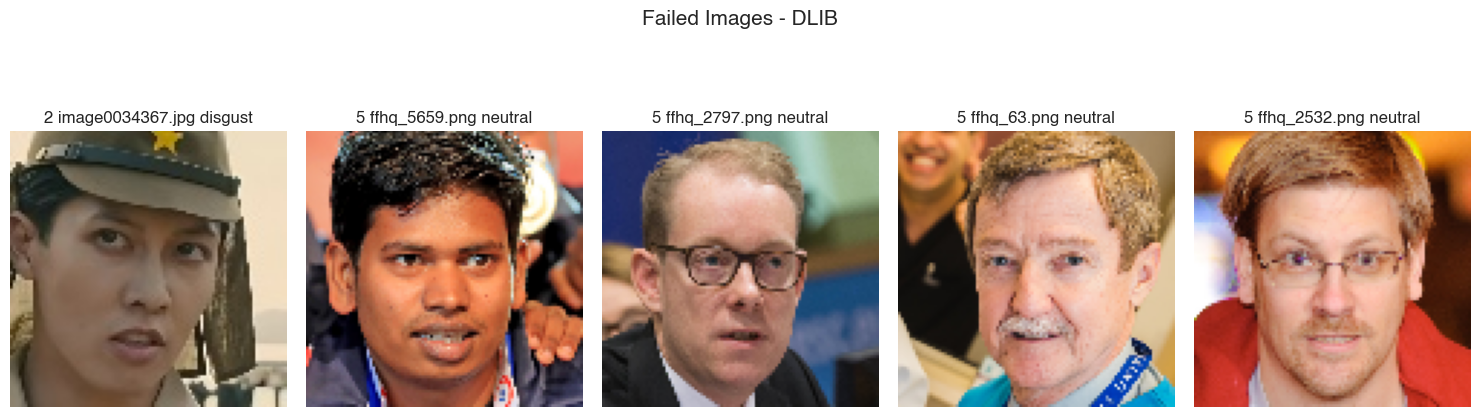

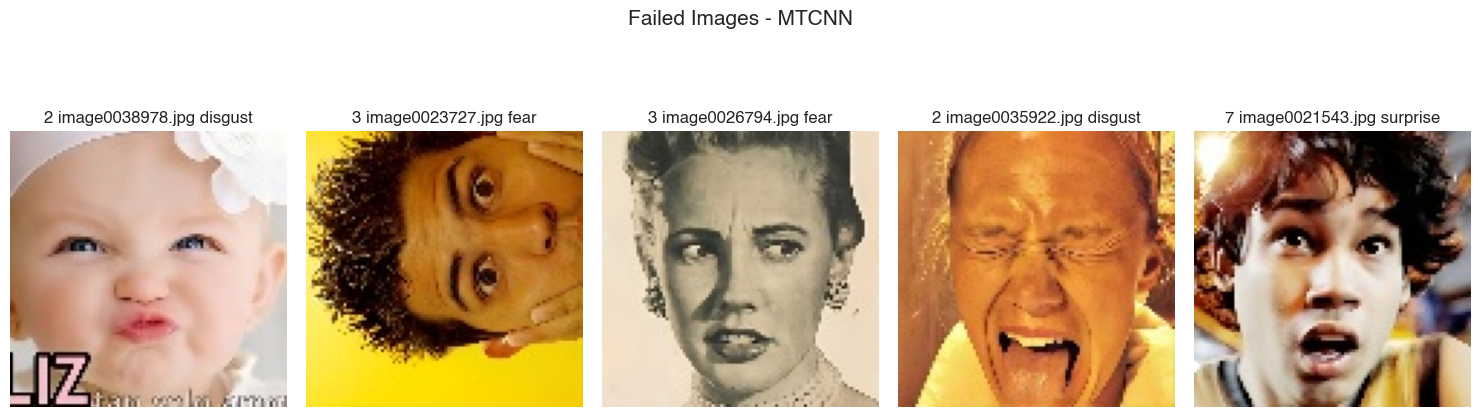

In [26]:
plot_random_images(failed_images_dlib_df, "Failed Images - DLIB")
plot_random_images(failed_images_mtcnn_df, "Failed Images - MTCNN")

### **¿Cuáles son las estadísticas resumidas del conjunto de datos?**


In [27]:
metrics_df.head()

img_path  class  class_index  \
0  /Users/lsfu/Desktop/MNA/Integrador/MTTX/data/N...  anger            0   
1  /Users/lsfu/Desktop/MNA/Integrador/MTTX/data/N...  anger            0   
2  /Users/lsfu/Desktop/MNA/Integrador/MTTX/data/N...  anger            0   
3  /Users/lsfu/Desktop/MNA/Integrador/MTTX/data/N...  anger            0   
4  /Users/lsfu/Desktop/MNA/Integrador/MTTX/data/N...  anger            0   

                                     flattened_image  brightness   contrast  \
0  [76, 74, 70, 64, 56, 47, 40, 36, 26, 25, 27, 3...  120.445312  71.937404   
1  [255, 255, 255, 255, 255, 255, 255, 255, 255, ...  126.274740  92.226579   
2  [123, 121, 120, 126, 125, 123, 128, 125, 127, ...   71.530707  59.452960   
3  [3, 4, 2, 37, 47, 47, 44, 41, 40, 40, 36, 35, ...  103.787326  72.089023   
4  [72, 69, 73, 88, 112, 127, 135, 142, 150, 163,...  159.461914  72.002177   

    entropy    sharpness      noise  width  height  channels format mode  
0  7.524433  8548.060622  92.455722     96      96         3   JPEG  RGB  
1  6.707150  3615.222438  60.126720     96      96         3   JPEG  RGB  
2  7.239850  4481.964179  66.947473     96      96         3   JPEG  RGB  
3  7.289602  2709.138228  52.049383     96      96         3   JPEG  RGB  
4  7.483420  4073.208343  63.821692     96      96         3   JPEG  RGB

In [28]:
quantitative_cols = ['brightness', 'contrast', 'entropy', 'sharpness', 'noise']
quantitative_stats = metrics_df[quantitative_cols].describe()
quantitative_stats.T

count         mean          std         min          25%  \
brightness  29042.0   116.678860    30.389543   20.244792    95.773600   
contrast    29042.0    59.397734    11.910265   20.145620    51.166423   
entropy     29042.0     7.378432     0.340350    4.207215     7.230222   
sharpness   29042.0  3240.951873  1875.406520  351.119388  2025.092965   
noise       29042.0    55.091458    14.348874   18.738180    45.001033   

                    50%          75%           max  
brightness   115.184733   136.243327    228.944987  
contrast      59.121610    67.331461    110.009117  
entropy        7.452283     7.610853      7.963585  
sharpness   2786.248903  3906.077324  43770.517474  
noise         52.784931    62.498619    209.214047

In [29]:
class_counts_summary = class_counts_mtcnn_df[["Clase", "Total"]]
class_counts_summary

Clase  Total
0     anger   3218
1  contempt   2871
2   disgust   2477
3      fear   3176
4     happy   5044
5   neutral   5126
6       sad   3091
7  surprise   4039

### **¿Hay valores atípicos en el conjunto de datos?**
Se identifican valores atípicos desde el brillo, contraste, entropía, ruido y sharpness de las imágenes.
Se podría ir  un nivel más abajo y verlo por clase desde el principio pero 


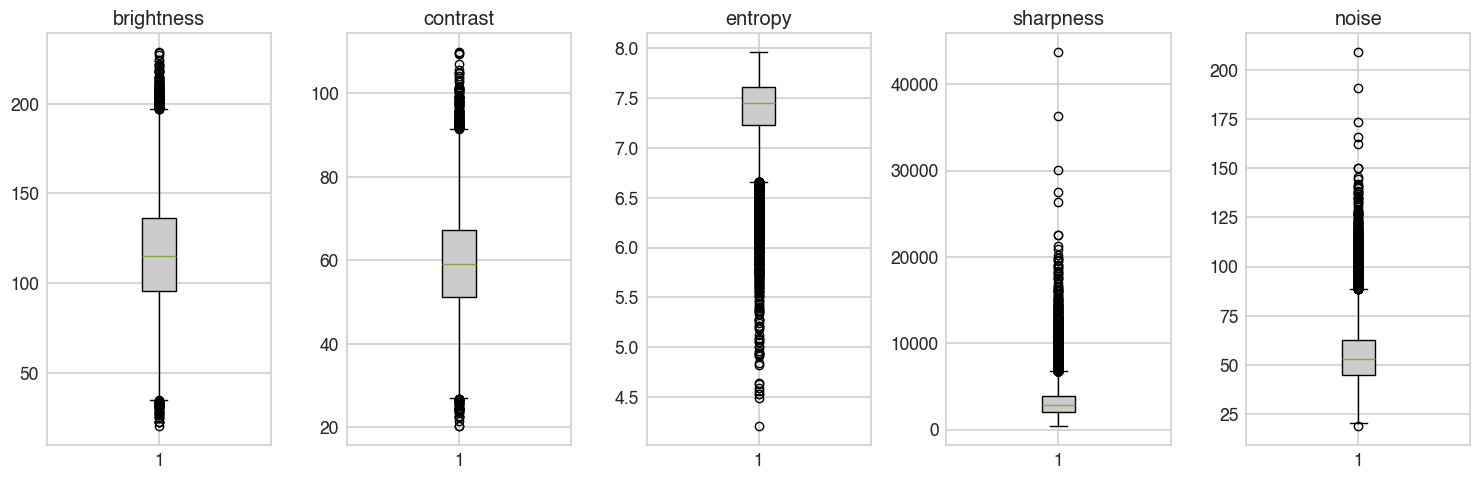

In [30]:
quantitative_cols = ["brightness", "contrast", "entropy", "sharpness", "noise"]

# Create boxplots for each feature
fig, axes = plt.subplots(1, len(quantitative_cols), figsize=(15, 5))
for i, col in enumerate(quantitative_cols):
    axes[i].boxplot(metrics_df[col].dropna(), vert=True, patch_artist=True)
    axes[i].set_title(col)
plt.tight_layout()
plt.show()

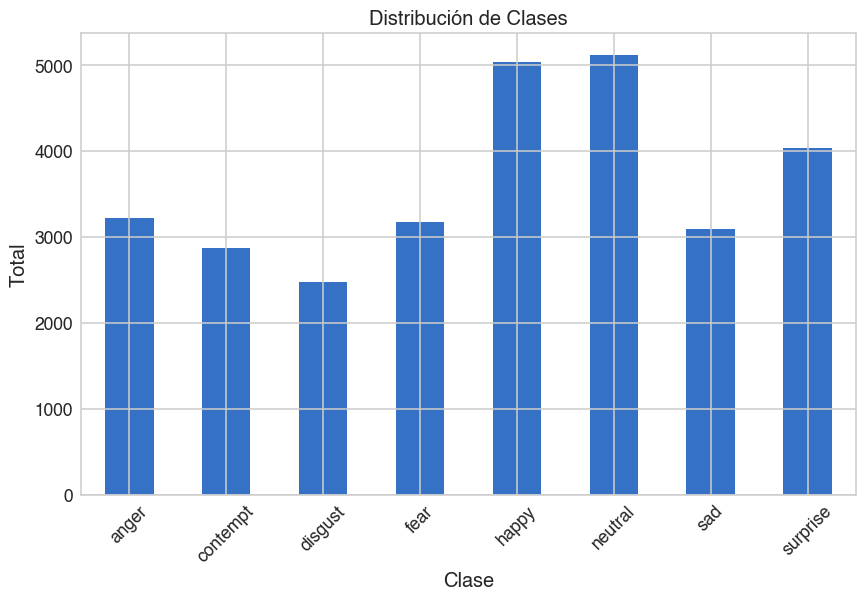

In [31]:
class_counts_summary.plot.bar(x="Clase", y="Total", legend=False, title="Distribución de Clases", figsize=(10, 6))
plt.xlabel("Clase")
plt.ylabel("Total")
plt.xticks(rotation=45)
plt.show()

 IQR

In [32]:
outliers_by_feature = {}

# Calculate outliers for each feature
for col in quantitative_cols:
    q1 = metrics_df[col].quantile(0.25)
    q3 = metrics_df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = metrics_df[(metrics_df[col] < lower_bound) | (metrics_df[col] > upper_bound)]

    grouped_outliers = {}
    for class_label in outliers["class"].unique():
        grouped_outliers[class_label] = outliers[outliers["class"] == class_label]

    outliers_by_feature[col] = grouped_outliers

outlier_stats = {col: sum(len(df) for df in grouped_outliers.values()) for col, grouped_outliers in outliers_by_feature.items()}
print("Outlier Counts:")
for feature, count in outlier_stats.items():
    print(f"{feature}: {count}")


Outlier Counts:
brightness: 205
contrast: 168
entropy: 1132
sharpness: 1375
noise: 772


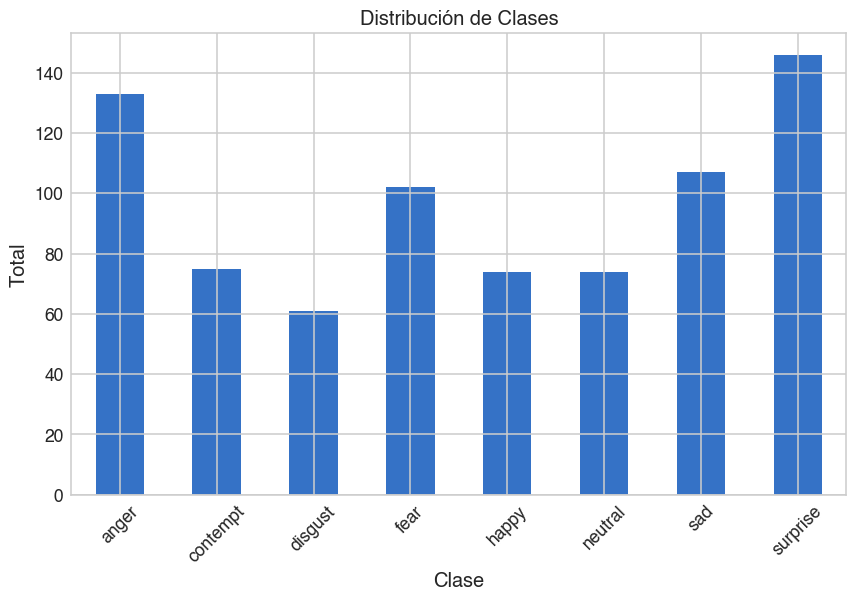

In [33]:
plot_data = pd.DataFrame([
    {"Clase": class_label, "Total": len(df)}
    for class_label, df in grouped_outliers.items()
])

# Plot the distribution
plot_data.plot.bar(x="Clase", y="Total", legend=False, title="Distribución de Clases", figsize=(10, 6))
plt.xlabel("Clase")
plt.ylabel("Total")
plt.xticks(rotation=45)
plt.show()

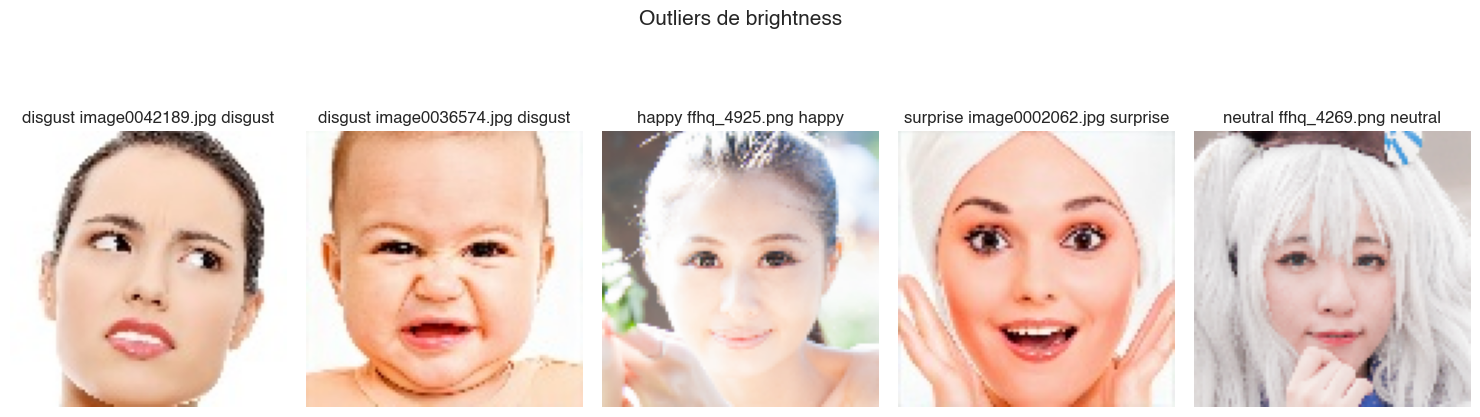

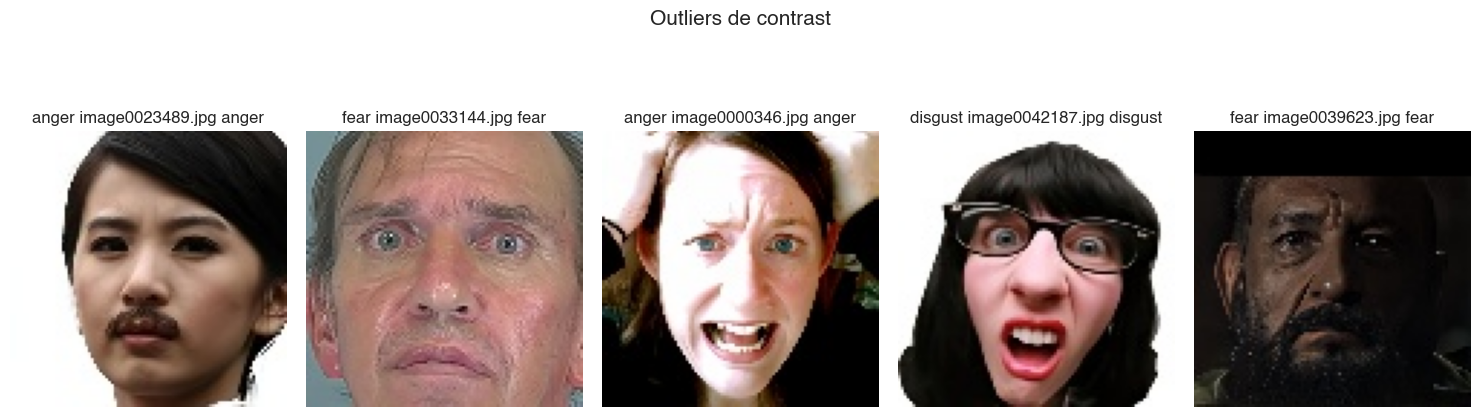

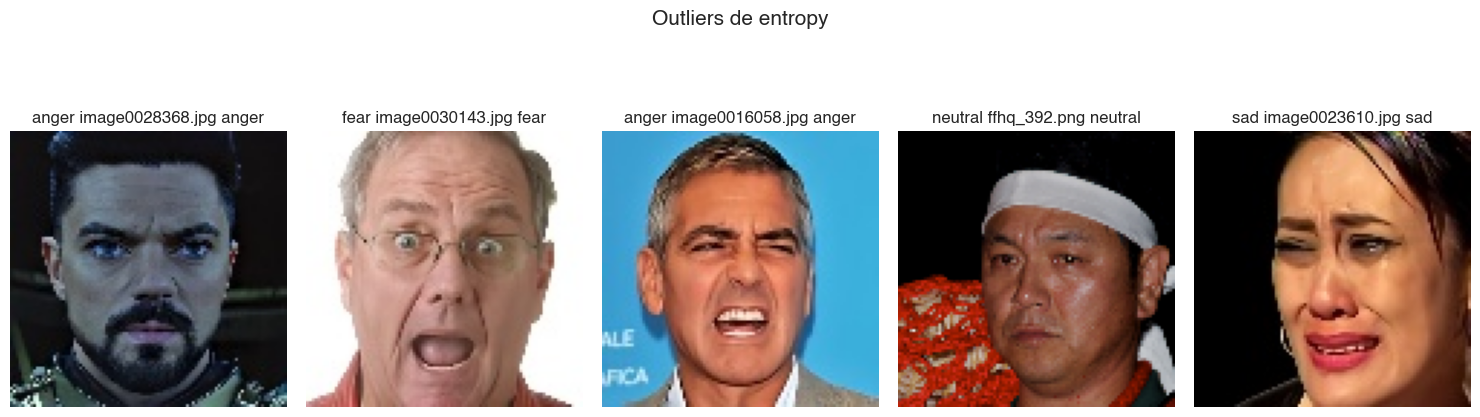

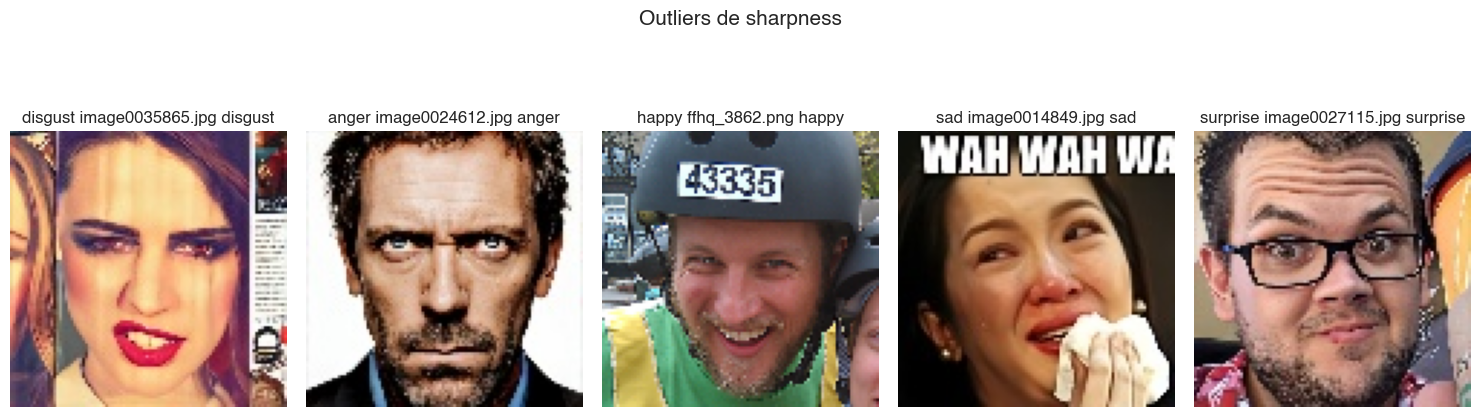

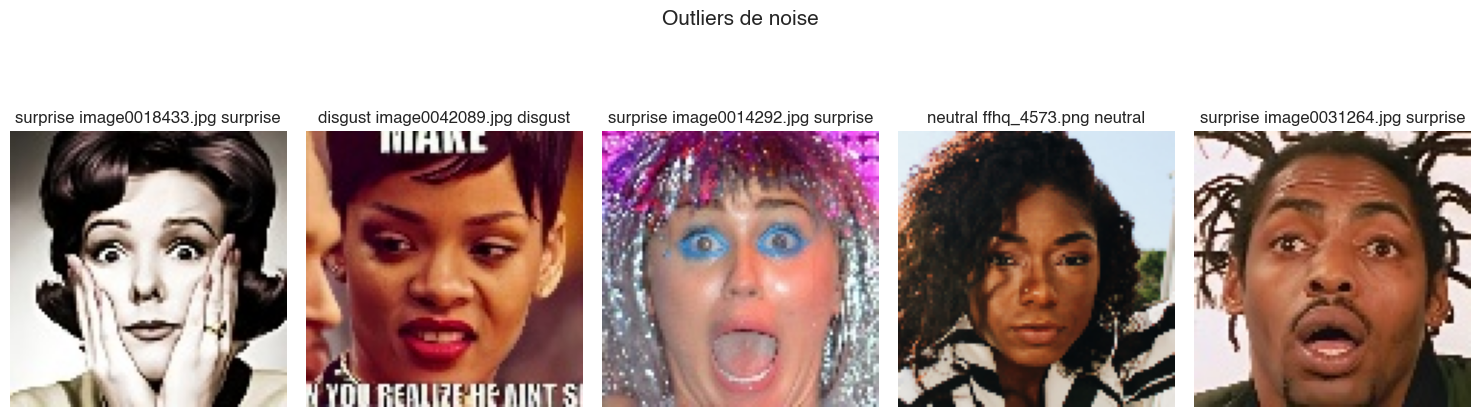

In [34]:
for feature, grouped_outliers in outliers_by_feature.items():
    combined_df = pd.concat(grouped_outliers.values(), ignore_index=True)
    title = f"Outliers de {feature}" 
    plot_random_images(combined_df, title=title)


In [35]:
#for class_label in outliers["class"].unique():
#class_outliers_df = outliers[outliers["class"] == class_label]
#plot_random_images(class_outliers_df, f"Outliers - {class_label}")
print("")

<p style="font-size: 16px;">
De las muestras parece ser que algunas imagenes podrían salvarse con normalización pero deberían eliminarse otras como texto. Justo como hicimos con el rostro. deberiamos ver si hay texto en las imagenes. no son utiles. 
</p>

### **¿Existen distribuciones sesgadas en el conjunto de datos? ¿Necesitamos aplicar alguna transformación no lineal?**



In [36]:
from scipy.stats import skew

skewness_by_feature = {}

for col in quantitative_cols:
    # Initialize dictionary to store skewness for each class
    grouped_skewness = {}
    
    for class_label in metrics_df["class"].unique():
        # Filter data for the current class
        class_df = metrics_df[metrics_df["class"] == class_label]
        
        # Calculate skewness for the feature
        if len(class_df[col]) > 1:  # Ensure there are enough data points
            feature_skewness = skew(class_df[col])
            grouped_skewness[class_label] = feature_skewness
        else:
            grouped_skewness[class_label] = None  # Not enough data to calculate skewness
    
    # Store skewness values for the feature
    skewness_by_feature[col] = grouped_skewness

# Print skewness results
print("Skewness by Feature and Class:")
for feature, grouped_skewness in skewness_by_feature.items():
    print(f"\nFeature: {feature}")
    for class_label, skewness_value in grouped_skewness.items():
        print(f"  {class_label}: {skewness_value:.2f}" if skewness_value is not None else f"  {class_label}: Insufficient Data")


Skewness by Feature and Class:

Feature: brightness
  anger: 0.18
  contempt: 0.11
  disgust: 0.31
  fear: 0.08
  happy: 0.20
  neutral: 0.20
  sad: 0.15
  surprise: 0.27

Feature: contrast
  anger: 0.15
  contempt: 0.08
  disgust: 0.10
  fear: 0.08
  happy: 0.12
  neutral: 0.13
  sad: 0.14
  surprise: 0.18

Feature: entropy
  anger: -1.49
  contempt: -1.49
  disgust: -1.28
  fear: -2.11
  happy: -2.01
  neutral: -1.78
  sad: -1.42
  surprise: -1.63

Feature: sharpness
  anger: 3.15
  contempt: 2.63
  disgust: 2.32
  fear: 1.88
  happy: 2.57
  neutral: 2.58
  sad: 4.79
  surprise: 2.46

Feature: noise
  anger: 1.19
  contempt: 1.18
  disgust: 1.05
  fear: 0.90
  happy: 1.20
  neutral: 1.22
  sad: 1.59
  surprise: 1.22


<p style="font-size: 16px;">
Se puede ver ligeramente algo de asimetria, esto puede refljear la emoción muchas de estas imagenes publicas tienden a perfer realidad. 
</p>

### **¿Se deberían normalizar las imágenes para visualizarlas mejor?**


<p style="font-size: 16px;">
Si es necesario, podemos observar una clara diferencia entre emociones y para el modelo se requiere estandarizar los datos. Normalizar las imágenes puede garantizar una visualización más consistente y facilitar el análisis de las diferencias entre emociones. Lo importante es que el modelo pueda identificar bien los rasgos sin tomar en cuenta las diferencias innatas.
</p>

# Conclusiones

<p style="font-size: 16px;">
Se debe de tomar una desición de acuerdo a las modificaciones aceptables del modelo. Por ejemplo, "Feliz" y "Neutral" son emociones que tienen más muestras que las demás, esto nos puede dar cierto problema de "class imbalance" pero tambien tenemos que tomar en cuenta la calidad de las imagenes.

El producto debería esperar imágenes de aún más alta calidad y fáciles de identificar un rostro. Por lo que veo aceptable tomar como base los resultados de la detección de dlib y eliminar estas muestras no optimas. El dataset se reduce en aproximadamente 18%. 
Después buscamos la manera de mejorar aún más las imágenes para que haya más **puntos clave** A esto podemos obviamente normalizar.

Podemos posiblemente recuperar este número mejorando las imágenes pero es mejor reducirlo
Si en un punto decidimos mejorar el sistema que detecta el rostro. Cambiar a algo como mtcnn aunque tarde más sigue siendo una opción que nos daría confiabilidad deque le estamos dando mejores inputs. 

En cuanto a la forma de programar cada sección, basarlo en funciones o clases se hizo desde el principio para facilitar cambios o mejoras futuros.
Hacer todo de esta forma incremento la complejidad del código pero la de lectura y uso se espera que, el balance entre los dos al momento es aceptable. En términos de MLOps, para tener buena gobernanza sobre esto, aún se requiere documentación de uso. 
</p>